In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#%matplotlib inline

In [110]:
# Set default setting for the figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 12) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize
#sns.set(style="white")
#sns.set_palette('Dark2') #Set2 also nice for qualitative
#paper_rc = {'lines.linewidth': 2, 'lines.markersize': 1}                  
#sns.set_context("paper", rc = paper_rc) 
col_pal=sns.color_palette("colorblind", 6).as_hex()
sns.set_palette(col_pal)

In [3]:
PATH_SAVE_FIGURES = "./OptInvest/"

# State and Control Variables Optimal Profiles

In [26]:
#choose the values for the parameters to iterate on

values=[150]

dfs={}
for i in range(len(values)):
    # create GEKKO model
    m = GEKKO(remote=False)
    # time points
    n=61
    tf=80
    # constants
    E0,Co2o,ccl,cof,kf,kns,cf,c1,c2= 556,280,0.03,0.03,0.07,0.02,0.129,.1,.1
    ncl,nof= 1./(1000*0.0317), 1./2900
    phi=(1.-1.)*E0
    Imax=10000.
    kc=500.
    rho=0.1
    #assign valus to parameter
    param=values[i]
    #decide the parameter to iterate on 
    kc=param
    #phi=phi_r/100.*E0
    m.time = np.linspace(0,tf,n)
    # controls
    u = m.MV(value=1,lb=0,ub=1)
    I = m.MV(value=0,lb=0,ub=Imax)
    u.STATUS = 1
    u.DCOST = 0
    I.STATUS = 1
    I.DCOST = 0
    #state variables
    x1 = m.Var(value=419) # Co2
    x2 = m.Var(value=32) # Kcl
    x3 = m.Var(value=0) # Kof
    t = m.Param(value=m.time)
    e = m.Intermediate(m.exp(-rho*t))
    # ode
    m.Equation(x1.dt() == (kf*(E0 - x2) - x3)*cf - kns*(x1-Co2o))
    m.Equation(x2.dt() == ncl * u * I -  ccl*x2)
    m.Equation(x3.dt() == nof*(1-u)*I -  cof*x3)
    m.Equation(E0-x2-phi>=0)
    
    
    #objective
    J = m.Var(value=0) # objective (profit)
    D = m.Var(value=0) # objective (damage)
    It = m.Var(value=0) # cumulative investment
    ut = m.Var(value=0) # cumulative share
    
    Jf = m.FV() # final objective
    Jf.STATUS = 1
    m.Connection(Jf,J,pos2='end')
    m.Equation(J.dt() == e* 
               ( kc/cf * (x1-Co2o) + u*I*(1 + c1*u*I) + (1-u)*I*(1+c2*(1-u)*I) ))
    m.Equation(D.dt() == e* 
               ( kc/cf * (x1-Co2o)))
    m.Equation(It.dt() == I)
    m.Equation(ut.dt() == u)
    m.Obj(Jf) # minimize cost
    m.options.IMODE = 6  # optimal control
    m.options.NODES = 3  # collocation nodes
    m.options.SOLVER = 1 # solver (3 IPOPT)
    m.options.MAX_ITER=2000
    m.solve(disp=True) # Solve, True to see the output
    
    print('Optimal Cost: ' + str(Jf.value[0]), 'Horizon: ' + str(tf))
    print('Max [CO2]: ' + str(np.max(np.array(x1.value))))
    print('Average annual investment: ' + str(It.value[-1]/tf))
    print('Average share: ' + str(ut.value[-1]/tf))

    
    df = pd.DataFrame(
        {   '$\tau$': m.time,
            '[CO$_2$]': np.array(x1.value),
            'EMI': kf*(E0 - np.array(x2.value) - np.array(x3.value)),
            'E$_{CL}$': np.array(x2.value),
            'NET': np.array(x3.value),
            '$\mathcal{C}$': np.array(J.value),
            'Damage':np.array(D.value),
            'Cumulative Investment':np.array(It.value),
            'I': np.array(I.value),
            'I$_{CL}$' : np.array(I.value)*np.array(u.value),
            '$\mu$': np.array(u.value)
         
        }
    )
    dfs[values[i]]=df
   

 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           12
   Intermediates:            1
   Connections  :            1
   Equations    :           10
   Residuals    :            9
 
 Number of state variables:           2520
 Number of total equations: -         2400
 Number of slack variables: -          120
 ---------------------------------------
 Degrees of freedom       :              0
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  9.62307E+15  1.63750E+01
    1  2.37020E+11  7.14781E+00
    2  1.40027E+21  4.95079E+00
    3  4.75943E+20  4.32215E+00
    4  3.33075E+1

In [29]:
panel=pd.concat(dfs,axis=1)
panel=panel.drop(0)
panel.columns.names=['Param', 'Variable']
panel.head()

Param          150                                                            \
Variable    $\tau$    [CO$_2$]        EMI   E$_{CL}$       NET $\mathcal{C}$   
1         1.333333  421.587744  36.764945  30.786442  0.000051  217525.32670   
2         2.666667  424.083665  36.558501  33.730460  0.005234  412679.66621   
3         4.000000  426.478770  36.360185  36.558575  0.010210  586376.66943   
4         5.333333  428.777097  36.169681  39.275282  0.014991  740829.74584   
5         6.666667  430.982524  35.986693  41.884799  0.019584  878050.40024   

Param                                                                           
Variable        Damage Cumulative Investment           I    I$_{CL}$     $\mu$  
1         217525.32670              0.000000  112.190234  100.685800  0.897456  
2         411350.34974            149.586978  112.170851  100.674308  0.897509  
3         583884.24530            299.148113  112.159100  100.661652  0.897490  
4         737319.63731            448.693580  112.140223  100.645302  0.897495  
5         873649.91827            598.213877  112.123922  100.632926  0.897515

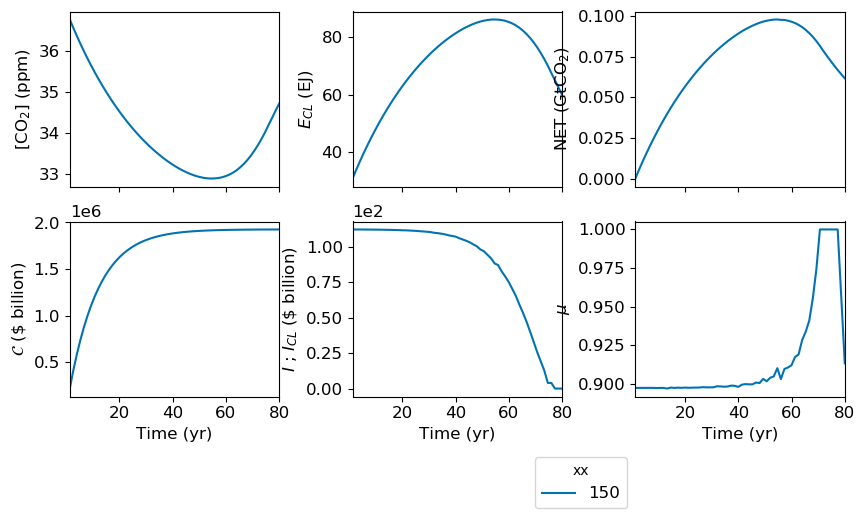

In [30]:
#panel at 6 variables
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 5), sharex = True)
plt.subplots_adjust(wspace = .35, hspace = .2)

axs=axs.ravel()

for i, value in enumerate(values):
    j=i
    i=0
    
    # Figure 1.
    panel[value].plot(x="$\tau$", y="EMI", ax=axs[i], legend=False)
    axs[i].set(xlabel="Time (yr)", ylabel="[CO$_2$] (ppm)")
    #axs[i].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    # Figure 2.
    panel[value].plot(x="$\tau$", y="E$_{CL}$", ax=axs[i+1], legend=False)
    axs[i+1].set(xlabel="Time (yr)", ylabel="$E_{CL}$ (EJ)")
    #axs[i+1].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    # Figure 3.
    panel[value].plot(x="$\tau$", y="NET", ax=axs[i+2], legend=False)
    axs[i+2].set(xlabel="Time (yr)", ylabel="NET (GtCO$_2$)")
    #axs[i+2].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    # Figure 4.
    panel[value].plot(x="$\tau$", y="$\mathcal{C}$", ax=axs[i+3], legend=False)
    #panel[value].plot(x="Year", y="Damage", ax=axs[i+3], legend=False,  linestyle='dashed')
    axs[i+3].set(xlabel="Time (yr)", ylabel="$\mathcal{C}$ (\$ billion)")
    axs[i+3].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    # Figure 5.
    panel[value].plot(x="$\tau$", y="I", ax=axs[i+4], c=col_pal[j], legend=False)
    #panel[value].plot(x="Year", y="I$_{CL}$", ax=axs[i+4], c=sns.color_palette('Dark2')[j], linestyle='dashed', legend=False)
    axs[i+4].set(xlabel="Time (yr)", ylabel="$I$ ; $I_{CL}$ (\$ billion)")
    axs[i+4].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    # Figure 6.
    panel[value].plot(x="$\tau$", y="$\mu$", ax=axs[i+5], legend=False)
    axs[i+5].set(xlabel="Time (yr)", ylabel="$\mu$")
    axs[i+5].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    
    
plt.legend(values, bbox_to_anchor = (0., -0.3), ncol = len(values), title="xx");
    
#fig.savefig(PATH_SAVE_FIGURES + "FIG3.png", bbox_inches = "tight", dpi = 300) 

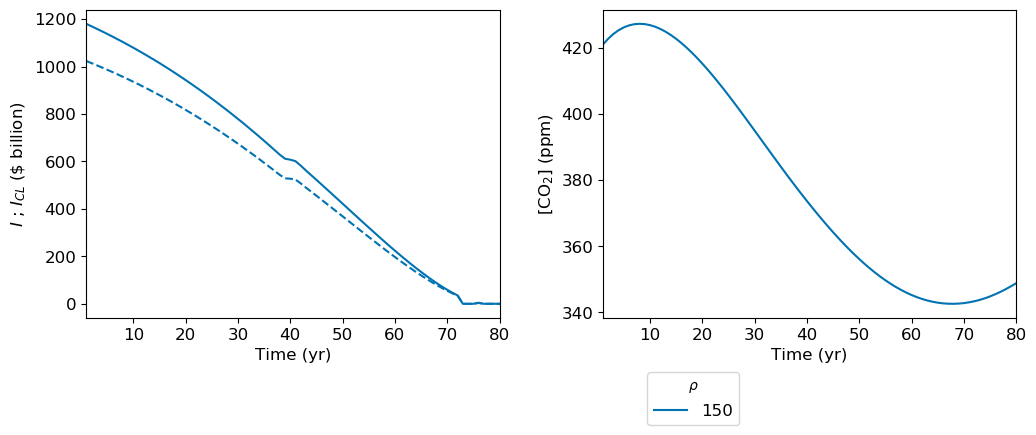

In [65]:
#Panel at 2 for Investment and Co2

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4), sharex = True)
plt.subplots_adjust(wspace = .25, hspace = .2)

axs=axs.ravel()

for i, value in enumerate(values):
    j=i
    i=0
    
    
    panel[value].plot(x="$\tau$", y="I", ax=axs[i], c=col_pal[j], legend=False)
    panel[value].plot(x="$\tau$", y="I$_{CL}$", ax=axs[i], c=col_pal[j], linestyle='dashed', legend=False)
    axs[i].set(xlabel="Time (yr)", ylabel="$I$ ; $I_{CL}$ (\$ billion)")
    #axs[i].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    #
    panel[value].plot(x="$\tau$", y="[CO$_2$]", ax=axs[i+1], legend=False)
    axs[i+1].set(xlabel="Time (yr)", ylabel="[CO$_2$] (ppm)")
    
    
plt.legend(values, bbox_to_anchor = (0.35, -0.15), ncol = len(values), title="$\\rho$");# (0.35, -0.15) $\\rho$, $\Phi$ (% $E_0$), I$_{max}$ (\$ billion),E$_{CL_{max}}$ (% E$_0$),  SCC (\$/tCO$_2$),$\\tau$ (yr)
    
#fig.savefig(PATH_SAVE_FIGURES + "F5AB.png", bbox_inches = "tight", dpi = 300) 

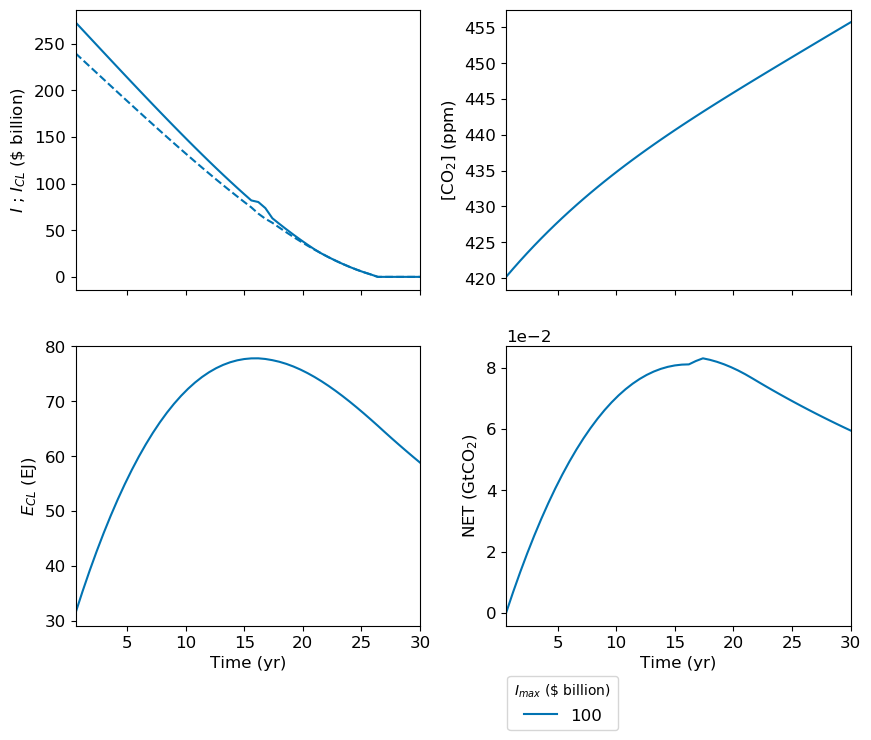

In [48]:
### Panel at 4 for Kcl and Kof

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8), sharex = True)
plt.subplots_adjust(wspace = .25, hspace = .2)

axs=axs.ravel()

for i, value in enumerate(values):
    j=i
    i=0

    panel[value].plot(x="$\tau$", y="I", ax=axs[i], c=col_pal[j], legend=False)
    panel[value].plot(x="$\tau$", y="I$_{CL}$", ax=axs[i], c=col_pal[j], linestyle='dashed', legend=False)
    axs[i].set(xlabel="Time (yr)", ylabel="$I$ ; $I_{CL}$ (\$ billion)")
    #axs[i].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    #
    panel[value].plot(x="$\tau$", y="[CO$_2$]", ax=axs[i+1], legend=False)
    axs[i+1].set(xlabel="Time (yr)", ylabel="[CO$_2$] (ppm)")
    
    panel[value].plot(x="$\tau$", y="E$_{CL}$", ax=axs[i+2], c=col_pal[j], legend=False)
    axs[i+2].set(xlabel="Time (yr)", ylabel="$E_{CL}$ (EJ)")
    #axs[i].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 0))
    #
    panel[value].plot(x="$\tau$", y="NET", ax=axs[i+3], legend=False)
    axs[i+3].set(xlabel="Time (yr)", ylabel="NET (GtCO$_2$)")
    axs[i+3].ticklabel_format(style = "sci", axis = "y", scilimits = (0, 3))
    
plt.legend(values, bbox_to_anchor = (0.35, -0.15), ncol = len(values), title="$I_{max}$ (\$ billion) ");
    
#fig.savefig(PATH_SAVE_FIGURES + "F6ABCD.png", bbox_inches = "tight", dpi = 300) 

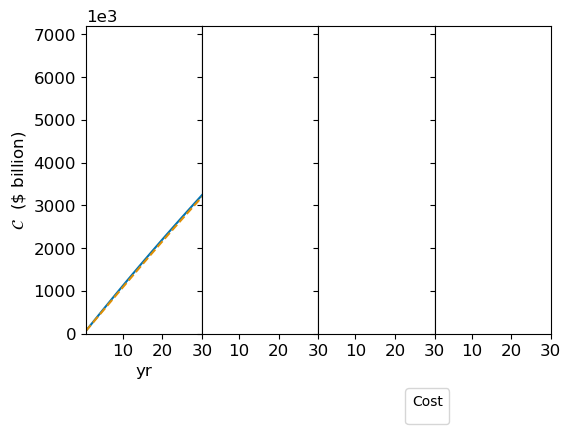

In [49]:
#plot for damage vs abatement costs
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (6, 4), sharex=True,sharey = True)
plt.subplots_adjust(wspace = 0, hspace = .0)

axs=axs.ravel()


for i, value in enumerate(values):
    
    
    panel[value].plot(x="$\tau$", y="$\mathcal{C}$", ax=axs[i], legend=False)
    panel[value].plot(x="$\tau$", y="Damage", ax=axs[i], legend=False,linestyle='dashed')
    axs[i].set( ylabel="$\mathcal{C}$  (\$ billion)", xlabel='yr')
    axs[i].set_ylim([0, 7200000])
    axs[i].ticklabel_format(style = "sci", axis = "y", scilimits = (3, 3))
    

plt.legend(["Total", "Damage"], bbox_to_anchor = (0.2, -0.15), ncol = len(values),title="Cost");

    
#fig.savefig(PATH_SAVE_FIGURES + "F3A.png", bbox_inches = "tight", dpi = 300) 


/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a19bb4828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


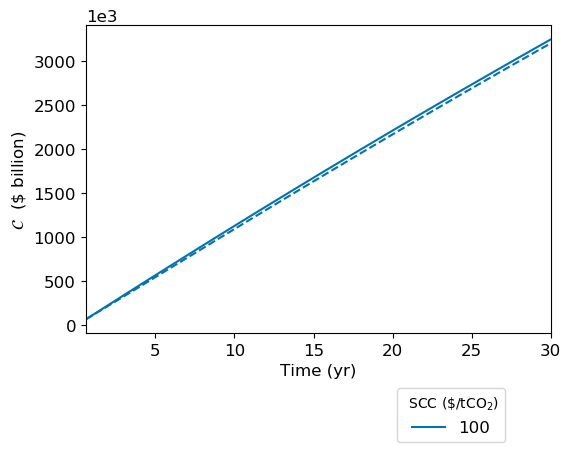

In [51]:
#plot for damage vs abatement costs, same plot
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4), sharex = True, sharey = True)
plt.subplots_adjust(wspace = .25, hspace = .0)

#axs=axs.ravel()


for i, value in enumerate(values):
    
    
    panel[value].plot(x="$\tau$", y="$\mathcal{C}$", ax=axs, legend=True,c=col_pal[i])
    panel[value].plot(x="$\tau$", y="Damage", ax=axs, label='_nolegend_', linestyle='dashed',c=col_pal[i])
    axs.set(xlabel="Time (yr)", ylabel="$\mathcal{C}$  (\$ billion)")
    axs.ticklabel_format(style = "sci", axis = "y", scilimits = (3, 3))
    #axs.xaxis.set_visible(False)
    #axs.yaxis.set_visible(False)
    

plt.legend(values, bbox_to_anchor = (.92, -0.15), ncol = len(values), title=" SCC (\$/tCO$_2$)");    #SCC (\$/tCO$_2$)  ; #E$_{CL_{max}}$ (% E$_0$)#
#fig.savefig(PATH_SAVE_FIGURES + "F3B.png", bbox_inches = "tight", dpi = 300) 


# Annual Cost

In [ ]:
#choose the values for the parameters to iterate on

values=[100, 300, 500, 1000]
tfs=[20,40,60, 80, 100]

df = pd.DataFrame(index = tfs, columns = values)
df.columns.name = "values"
df.index.name = "tfs"

#df for CO2 max
dfC = pd.DataFrame(index = tfs, columns = values)
dfC.columns.name = "values"
dfC.index.name = "tfs"
 
    
dfs={}
for j in range(len(tfs)):
    for i in range(len(values)):
        # time points
        n=41
        J0 = np.nan
        counter=0
        while J0 is np.nan and counter<=3:
            print("ciao")
            try:
                # create GEKKO model
                m = GEKKO(remote=False)
                # constants
                E0,Co2o,ccl,cof,kf,kns,cf,c1,c2= 556,280,0.03,0.03,0.07,0.02,0.129,.1,.1
                ncl,nof= 1./(1000*0.0317), 1./2900
                phi=(1.-1.)*E0
                Imax=10000.
                kc=80.
                rho=0.0
                #assign valus to parameter
                param=values[i]
                #decide the parameter to iterate on 
                Imax=param
                #phi=phi_r/100.*E0
                tf=tfs[j]
                m.time = np.linspace(0,tf,n)
                # controls
                u = m.MV(value=1,lb=0,ub=1)
                I = m.MV(value=0,lb=0, ub=Imax)
                u.STATUS = 1
                u.DCOST = 0
                I.STATUS = 1
                I.DCOST = 0
                #state variables
                x1 = m.Var(value=419) # Co2
                x2 = m.Var(value=32) # Kcl
                x3 = m.Var(value=0) # Kof
                t = m.Param(value=m.time)
                e = m.Intermediate(m.exp(-rho*t))
                # ode
                m.Equation(x1.dt() == (kf*(E0 - x2) - x3)*cf - kns*(x1-Co2o))
                m.Equation(x2.dt() == ncl * u * I -  ccl*x2)
                m.Equation(x3.dt() == nof*(1-u)*I -  cof*x3)
                m.Equation(E0-x2-phi>=0)
                
                #objective
                J = m.Var(value=0) # objective (profit)
                D = m.Var(value=0) # objective (damage)
                It = m.Var(value=0) #cumulative investment
                Jf = m.FV() # final objective
                Jf.STATUS = 1
                m.Connection(Jf,J,pos2='end')
                m.Equation(J.dt() == e* 
                           ( kc/cf * (x1-Co2o) + u*I*(1 + c1*u*I) + (1-u)*I*(1+c2*(1-u)*I) ))
                m.Equation(D.dt() == e* 
                           ( kc/cf * (x1-Co2o) ))
                m.Equation(It.dt() == I)
                m.Obj(Jf) # minimize cost
                m.options.IMODE = 6  # optimal control
                m.options.NODES = 3  # collocation nodes
                m.options.SOLVER = 1 # solver (3 IPOPT)
                m.options.MAX_ITER=2000
                m.solve(disp=True) # Solve, True to see the output
                J0=Jf.value[0]
                I0=It.value[-1]           
            except:
                n=n+40
                counter+=1
                
        print('Optimal Cost: ' + str(J0), 'Horizon: ' + str(tf), 'Param: ' + str(param))
        print('Cumulative investment: ' + str(I0), 'Horizon: ' + str(tf), 'Param: ' + str(param))
        #print('Cumulative investment: ' + str(It.value))
                           
        #print('Damage: ' + str(D[-1]), 'Horizon: ' + str(tf), 'Param: ' + str(param))
        

        #store result
        df.iloc[j,i] =J0/tf  #divide by the horizon to have the annual cost
        dfs[values[i]]=df
        dfC.iloc[j,i] = np.max(np.array(x1.value))

In [ ]:
#df for CO2 conc max for each simulation
dfC.head()

In [ ]:
#plot CO2 max for different planning horizons and chosen parameter (choose param in legend title)
#sns.set_palette('RdGy') 

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), sharex = True)

for i, value in enumerate(values):
    dfC[value].plot(ax = ax, style = ".-", legend = False)
    ax.set(xlabel = "$\\tau$ (yr)", ylabel = "Max [CO$_2$] (ppm)")
    ax.ticklabel_format(style = "sci", axis = "y")
    ax.set_ylim([425, 490])
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    
#plt.legend(values, bbox_to_anchor = (1.05, -0.12), ncol = len(values),  title=" $\Phi$ (% E$_0$)");  #$\Phi$ (% E$_0$)  ; SCC (\$ / tCO$_2$) 1.075
#fig.savefig(PATH_SAVE_FIGURES + "F7B.png", bbox_inches = "tight", dpi = 300) 


In [ ]:
df.head()

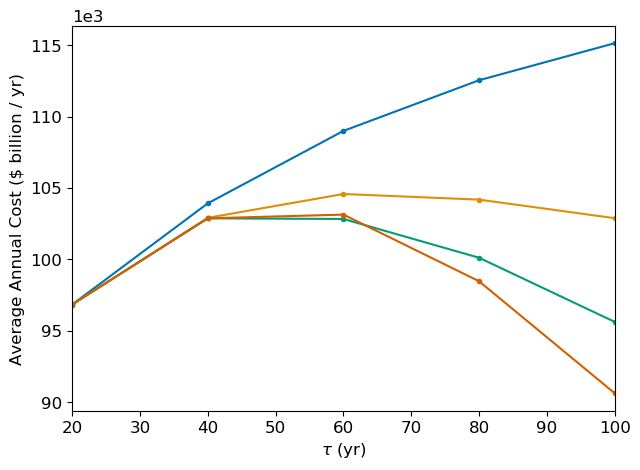

In [109]:
#plot the annual cost for different planning horizons and chosen parameter (choose param in legend title)
#sns.set_palette('RdGy') 

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), sharex = True)

for i, value in enumerate(values):
    df[value].plot(ax = ax, style = ".-", legend = False)
    ax.set(xlabel = "$\\tau $ (yr)", ylabel = "Average Annual Cost ($ billion / yr)")
    ax.ticklabel_format(style = "sci", axis = "y", scilimits = (3, 3))
    #ax.set_ylim([35*10**3, 140*10**3])
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    
#plt.legend(values, bbox_to_anchor = (1.05, -0.12), ncol = len(values),  title="$\Phi$ (% E$_0$) ");  #$\Phi$ (% E$_0$)    SCC (\$ / tCO$_2$)
#fig.savefig(PATH_SAVE_FIGURES + "F7A.png", bbox_inches = "tight", dpi = 300) 
